# Create Inversion Net for NEUP project

For this project a data driven inversion procedure for ultrasonic waves is developed to check the thickness (and uniformness) of a coating. The original data is stored in a .csv file and contains the 2D-FFT data of simulations done in Abaqus, but a .png image is extracted to reduce the amount of data used. The underlying model for this research is a Zirconium-4 based alloy with a Chrome coating.

Within this Jupyter notebook the following object are created:
1. **Dataset** - an object which can load the data and labels given an index:
        1.1 create a data loader to load train and test data and label, respectively.
        1.2 utilize some data preprocessing and maybe data augmentation to increase performance. Maybe reducing the size of the data is necessary here.
2. **Model** - an object that contains the network architecture definition:
        2.1 Try a simple network structure for training and see if the network is somewhat better than chance. Add Resnet18 or such later on too.
        2.2 (maybe) add some more advanced features like from the Pyramid Parsing Network/Dilated Convolutions if we need a larger receptive field.
        2.3 (maybe) try the Physics Driven Network Architecture approach
3. **Loss function** - a function that measures how far the network output is from the ground truth label.
4. **Optimizer** - an object that optimizes that network parameters to reduce the loss value

Disclaimer: this notebook is partly based on James Hays outstanding class CS6476 Computer Vision.

<font size="2">
-> load the autoreload function first. This way changes in the code are directly
updated and the notebook does not need to get restarted.
</font>

In [1]:
use_colab = False
use_cluster = False

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# data_path = '../dl_code/data/' if not use_colab else './data/'
# model_path = '../dl_code/model_checkpoints/' if not use_colab else './model_checkpoints/'
# save_path = '../dl_code/trained_models/' if not use_colab else './trained_models/'

The unit tests help while coding and can be used to test if the code
behaves like it should.

In [4]:
import os
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import copy

if not use_cluster:
    from dl_code.data_transforms import (get_fundamental_transforms,
                                         get_fundamental_augmentation_transforms,
                                         get_fundamental_normalization_transforms,
                                         get_all_transforms)
    from dl_code.simple_net import SimpleNet
    from dl_code.simple_net_final import SimpleNetFinal
    from dl_code.simple_net_big import SimpleNetBig
    from dl_code.my_resnet import MyResNet18
    from dl_code.optimizer import get_optimizer
    from dl_code.runner import Trainer
    from dl_code.image_loader import ImageLoader
    from dl_code.dl_utils import save_trained_model_weights
    from dl_code.stats_helper import compute_mean_and_std
    from dl_code.confusion_matrix import (generate_confusion_data, generate_confusion_matrix,
                                             plot_confusion_matrix, get_pred_images_for_target,
                                             generate_and_plot_confusion_matrix)

if use_cluster:
    from data_transforms import (get_fundamental_transforms,
                                         get_fundamental_augmentation_transforms,
                                         get_fundamental_normalization_transforms,
                                         get_all_transforms)
    from simple_net import SimpleNet
    from simple_net_final import SimpleNetFinal
    from simple_net_big import SimpleNetBig
    from my_resnet import MyResNet18
    from optimizer import get_optimizer
    from runner import Trainer
    from image_loader import ImageLoader
    from dl_utils import save_trained_model_weights
    from stats_helper import compute_mean_and_std
    from confusion_matrix import (generate_confusion_data, generate_confusion_matrix,
                                             plot_confusion_matrix, get_pred_images_for_target,
                                             generate_and_plot_confusion_matrix)



In [5]:
if not use_cluster:
    from unit_tests.utils import verify

    from unit_tests.test_stats_helper import test_mean_and_variance

    from unit_tests.test_image_loader import (test_dataset_length, test_unique_vals,
                                                    test_class_values, test_load_img_from_path)

    from unit_tests.test_data_transforms import (test_fundamental_transforms,
                                                 test_data_augmentation_transforms,
                                                 test_data_augmentation_with_normalization_transforms)

    from unit_tests.test_simple_net import test_simple_net

    from unit_tests.test_simple_net_final import test_simple_net_final

    from unit_tests.test_my_resnet import test_my_resnet

    from unit_tests.test_dl_utils import test_compute_accuracy, test_compute_loss

In [6]:
torch.cuda.empty_cache()
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU
print(f'is_cuda = {is_cuda}')
print(torch.cuda.is_available())

is_cuda = True
True


In [7]:
data_path = '../dl_code/data/' if not use_colab else './data/'
model_path = '../dl_code/model_checkpoints/' if not use_colab else './model_checkpoints/'
save_path = Path.cwd() / 'trained_models' if not use_colab else './trained_models/'

This has been the important part which needs to be run everytime the Jupyter server is started
again. From this point, it can be jumped to whatever network should be worked on. The
following tests on dataloader/... are optional to run when the got passed once and work.
___________________


## Part 1: Dataset and Dataloader

First, the dataset needs to be created. In `dl_code/image_loader.py` a `ImageLoader` class is constructed. The idea is to store the paths to all the images in the dataset, and then be able to provide the image file path and the respective ground truth label when given the index.

Use baseline from proj5 to create the dispersion loader:


In [ ]:
# print("Testing dispersion loader (length):", verify(test_dataset_length))
# print("Testing dispersion loader (values):", verify(test_unique_vals))
# print("Testing dispersion loader (classes):", verify(test_class_values))
# # print("Testing your image loader (paths):", verify(test_load_img_from_path))

### Data transforms

The function `get_fundamental_transforms()` in `data_transforms.py` is compiling the following fundamental transforms:

1. Resize the input image to the desired shape,
2. Convert it to a Torch tensor.

In [ ]:
# print("Testing your fundamental data transforms: ", verify(test_fundamental_transforms))

Plot image after transformation just for visualization purposes to understand what is going on in transformation.

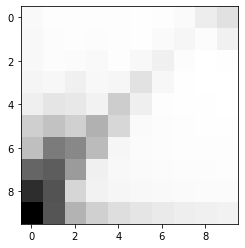

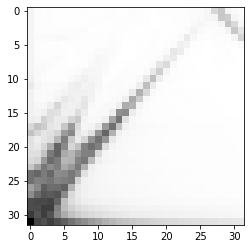

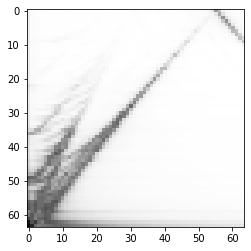

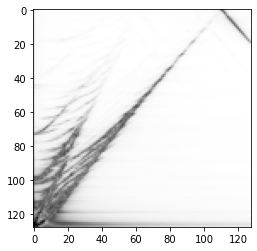

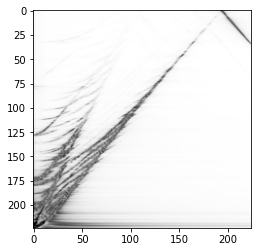

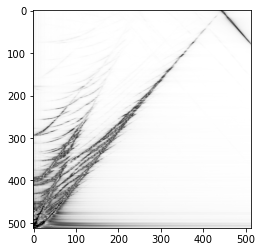

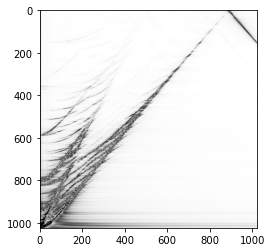

In [11]:
# from torch.utils.data import DataLoader
# imshow_is_list = [10, 32, 64, 128, 224, 512, 1024]
# # imshow_is_list = [512]
#
# for imshow_is in imshow_is_list:
#     imshow_inp_size = (imshow_is,imshow_is)
#
#     # data_dir = Path().parent.resolve() / 'data'
#     data_dir = Path().parent.resolve() / 'example_images'
#
#     imshow_dataset = ImageLoader(
#         data_dir, split="train", transform=get_fundamental_transforms(imshow_inp_size)
#     )
#
#     # img = imshow_dataset.load_img_from_path(
#     #     Path("C:\\Users\\Max\\OneDrive - Georgia Institute of Technology\\Documents\\Uni Gatech MSC\\"
#     #          "A Lab Research Wave CEE\\python_scripts\\dl_code\\example_images\\train\\1\\"
#     #          # "10-25_12-29-39_max_analysis_job_10-26_15-27-20_contf_300_375_cnn.png")
#     # )
#
#     img = imshow_dataset.load_img_from_path(
#         Path('C:\\Users\\Max\\Documents\\analysis_2dfft\\200_1_1_1_000\\'
#              '10-14_16-24-27_max_analysis_job_11-21_12-45-13_contf_300_200_cnn.png')
#     )
#
#     # print(img)
#     # plt.figure()
#     # plt.imshow(img)
#     # plt.title('PIL Image')
#     #
#     # np_img = np.array(img)
#     # print(np_img.shape)
#     # plt.figure()
#     # plt.imshow(np_img, cmap="Greys")
#     # plt.title('np Image')
#
#     imshow_loader = DataLoader(
#         imshow_dataset, batch_size=1, shuffle=False,num_workers=1, pin_memory=True
#     )
#
#     i = 0
#     for (x, y) in imshow_loader:
#         i += 1
#         if i == 24:
#             x_work = x.clone()
#     # print(i)
#
#     x_work = x.clone()
#     # print(x_work.shape)
#     # print(type(x_work))
#
#     x_permute = x_work.permute(2, 3, 1, 0)
#     # print(x_permute.shape)
#     # print(type(x_work))
#
#     x_np = x_permute.numpy()
#     x_np = np.squeeze(x_np, axis=(2,3))
#     # print(x_np.shape)
#     # print(type(x_np))
#
#     # print(y)
#
#     plt.figure()
#     plt.imshow(x_np, cmap='Spectral')
#     plt.imshow(x_np, cmap="Greys")
#     if False:
#         plt.savefig(f'../dl_code/figures/change_input_res/{imshow_is}x{imshow_is}_Example_Image_2_BW.pdf',
#                     backend='pgf', format='pdf', dpi=300)
#     if False:
#         plt.savefig(
#             f'../dl_code/figures/change_input_res/{imshow_is}x{imshow_is}_Example_Image_2_BW.png',
#             dpi=500
#         )

## Part 2: Model

The data should be ready now. But this is based on that the image pipeline works for dispersion data too! __Likelihood is pretty high that this is not working with the data I have. Construct the pipeline first and then see how reducing the input size could work besides converting 2D-FFT data to PNG and then cropping it!__

### Part 2.1 Simple Net

Start with a simple 2-layer model in simple_net.py. Here, 2 layers refers to 2 convolutional layers with supporting utilities like ReLU, MaxPooling, and Fully connected layers (and configuration with proper parameters to make the tensor flow).

In [ ]:
# inp_size = (64, 64)
# print("Testing your SimpleNet architecture: ", verify(test_simple_net))


In [ ]:
# simple_model = SimpleNet()
# print(simple_model)

### Loss function

This is a binary classification problem so a simpler loss function might be suitable. Continue to use the simple standard multiclass loss first (currently active NLLLoss). Maybe switch to a SoftMarginLoss or such which has advantages on 2 classes classification problems.

The loss function can be found in `self.loss_criterion` in `simple_net.py`.

In [ ]:
# print(simple_model)

In [ ]:
# num_params = 0
# for param in simple_model.parameters():
#     num_params += param.numel()
#
# print(f'number of parameters without residual block = {num_params}')

### Optimizer

The following cell is specifying the configuration of th optimizer. The initial values were tuned by me and might need to be tuned again as soon as the model changes or new data gets available.

In [ ]:
# # # TODO: add a decent initial setting and tune from there.
# #  The values are intentionally bad at the beginnging.
# optimizer_config = {
#   "optimizer_type": "adam",
#   "lr": 4e-4, #1e-3, -good #
#   "weight_decay": 1e-5, #1e-7,-good#1e-2,
#   "momentum": 1e-7 # no momentum for Adam
# }
#
# # good values when not BCELoss is used
# #   "optimizer_type": "adam",
# #   "lr": 1e-2, #1e-3, -good
# #   "weight_decay": 1e-7, #1e-7,-good#1e-2,
# #   "momentum": 1e-7 # no momentum for Adam

Some ideas and remarks about hyperparameter tuning:
- if the loss decreases very slowly, try increasing the value of the learnin rate (lr)
- Keep the value of the weight decay really low in the beginning
- Adjust the learning rate first in big steps, than go into fine-tuning
- increase the validation accuracy by a little bit by increasing the weight decay to prevent overfitting.


The file `get_optimizer.py` contains the function `get_optimizer()`. The unit test checks for three different optimizers but usually Adam gets the job done pretty well and should be tested first.

In [ ]:
# optimizer = get_optimizer(simple_model, optimizer_config)

### Trainer

Following, the trainer for the model will be defined. For this, in `dl_utils.py` the function `compute_loss()` and `compute_accuracy()` have been defined.

In [ ]:
# print("Testing your trainer (loss values): ", verify(test_compute_loss))
# print("Testing your trainer (accuracy computation): ", verify(test_compute_accuracy))

The next thing is to put all of this (model, optimizer, transforms for both the training and the test set) together into the trainer and start training the network. If the implementation above was done right and I am really lucky, there should be a decreasing loss value.

The laptop CPU should be sufficient to handle the training process for this network and should not take too long (15 min max) for the simple network I am using here. One option might be to decrease the value for `num_epochs` to quickly experiment with the optimization parameters. The default value is 30 and I need to see if this is helping me in any way or not, but increasing this value might improve the performance too.

___Note:___ for this project until now I use the training set as the validation set (i.e. using it to guide decisions about models and hyperparameters while training. As soon as I obtain enough samples I need to change that so that I am not interacting with the test set until reporting the final result!)

In [ ]:
# # re-init the model so that the weights are all random
# simple_model_base = SimpleNet()
# optimizer = get_optimizer(simple_model_base, optimizer_config)
#
# trainer = Trainer(data_dir=data_path,
#                   model = simple_model_base,
#                   optimizer = optimizer,
#                   model_dir = os.path.join(model_path, 'simple_net'),
#                   train_data_transforms = get_fundamental_transforms(inp_size),
#                   val_data_transforms = get_fundamental_transforms(inp_size),
#                   batch_size = 10, # 5 seems to work nice
#                   load_from_disk = False,
#                   cuda = is_cuda
#                  )

<font size="2">
Hint: if the 'matrix dim 1 must match mat2 dim 0' error comes up: make sure you are
using the right input size in the network.
</font>

In [ ]:
# %%time
# trainer.run_training_loop(num_epochs=60) #was 150, 30 - go to 15 for the tuning the parameters

After finishing the training process, the loss and the accuracy history can be plotted. Additionally, check the final accuracy for both training and test data.

In [ ]:
# trainer.plot_loss_history()
# trainer.plot_accuracy()

In [ ]:
# train_accuracy = trainer.train_accuracy_history[-1]
# validation_accuracy = trainer.validation_accuracy_history[-1]
# print('Train Accuracy = {}; Validation Accuracy = {}'.format(train_accuracy, validation_accuracy))


### SAVE the model!!!
If the model is satisfying, make sure to save it properly!

In [ ]:
# save_trained_model_weights(simple_model,
#                          out_dir = '../dl_code/trained_models/')

## Part 2.2 Simple Net with additional modifications

In the first part I implemented a really basic convolutional neural network. To improve the performance, some tricks are implemented in the following.

### Improve training data size with color 'jittering'

For the data .png plots are used which are based on a certain colormap defined by the creator. Clipping the data has an additional effect on the color of the plot. This colormap is quite arbitrarily defined. To address this problem, color 'jittering' is introduced

In [ ]:
# print("Testing your data transforms with data augmentation: ", verify(test_data_augmentation_transforms))
# print("Testing your normalized data transforms: ", verify(test_data_augmentation_with_normalization_transforms))

### Improve training data set with zero-centering and variance-normalization

Additionally, the dataset needs to be 'zero-centered' and 'normalized', so that each entry has zero mean and overall standard deviation of 1.

In `stats_helper.py` there is a function `compute_mean_and_std()` which computes the mean and standard deviation of __both__ the training set.

In [ ]:
# # print("Testing your mean and std computation: ", verify(test_mean_and_variance))
# # dataset_mean, dataset_std = compute_mean_and_std(data_path)
# # print(f'dataset_mean = {dataset_mean},\ndataset_std = {dataset_std}')
#
# # from compute_mean_and_std(data_path)
# dataset_mean, dataset_std = 0.3150067262879628, 0.1554323642999201


### Improve the network architecture

As a last improvement, the network architecture is adjusted by
1. Adding a dropout layer
2. Adding some more 'conv/pool/relu' layers
3. Adding a batch normalization layer after each convolutional layer
(except for the last)

In [ ]:
# print("Testing your SimpleNetFinal architecture: ", verify(test_simple_net_final))

In [ ]:
# simple_model_final = SimpleNetFinal()
# print(simple_model_final)

Similar as for the simpler network above, in the following cell the optimizer is getting configured. Keep in mind that the hyper parameters might needs some additional tuning for a new dataset or changes in the network structure!

In [ ]:
# # TODO: add a decent initial setting and tune from there.
# optimizer_config = {
#   "optimizer_type": "adam",
#   "lr": 1e-4,  #-4
#   "weight_decay": 1e-6,  #-8
#   "momentum": 1e-7
# }

The following 'training' cell will take longer than the training before, as there is more data and the model is a little bit more complex now. However, it should finish within 10-20 minutes. Start with a small `num_epochs` first to tune the hyper parameters and go to higher values to increase performance then.

In [ ]:
# simple_model_final = SimpleNetFinal()
# optimizer = get_optimizer(simple_model_final, optimizer_config)
#
# trainer = Trainer(data_dir=data_path,
#                   model = simple_model_final,
#                   optimizer = optimizer,
#                   model_dir = os.path.join(model_path, 'simple_model_final'),
#                   train_data_transforms = get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
#                   val_data_transforms = get_fundamental_normalization_transforms(inp_size, [dataset_mean], [dataset_std]),
#                   batch_size = 10, #32,
#                   load_from_disk = False,
#                   cuda = is_cuda,
#                   save_freq = 1
#                  )

In [ ]:
# %%time
# trainer.run_training_loop(num_epochs=30) # was 30

Again, similar to above, now the loss an accuracy history should be plotted!

In [ ]:
# trainer.plot_loss_history()
# trainer.plot_accuracy()

In [ ]:
# train_accuracy = trainer.train_accuracy_history[-1]
# validation_accuracy = trainer.validation_accuracy_history[-1]
# print('Train Accuracy = {}; Validation Accuracy = {}'.format(train_accuracy, validation_accuracy))

Get the number of parameters in model

In [ ]:
# num_params = 0
# for param in simple_model_final.parameters():
#     num_params += param.numel()
#
# print(f'number of parameters without residual block for simple_model_final = {num_params}')

### SAVE the trained model!!!

In [ ]:
# save_trained_model_weights(simple_model,
#                            out_dir = '../dl_code/trained_models/')


## Part 2.3 Simple Net with bigger input dimension

Until now the input size of the network was 61x61 pixels. Now the input dimension should be increased to capture more details in the data, i.e. a varying thickness of the coating infront of the sampling nodes. For this, a copy if `simple_net_final.py` is used in `simple_net_big.py` where the network architecture is adjusted to fit the now bigger input data.

In [ ]:
# inp_size = (224,224)
inp_size = (512, 512)

In [ ]:
# simple_model_big = SimpleNetBig()
# print(simple_model_big)

In [ ]:
dataset_mean, dataset_std = 0.3150067262879628, 0.1554323642999201

And again, make sure that the hyper parameters are chosen wisely to get the best out of the network during training! The network changed so there might be the need of different values for the optimizer.

In [ ]:
# TODO: add a decent initial setting and tune from there.
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-4,  #-4
  "weight_decay": 1e-6,  #-8
  "momentum": 1e-7
}

In [ ]:
simple_model_big = SimpleNetBig()

load_trained_model = False
if load_trained_model:
    simple_model_big_info = torch.load(save_path / 'trained_SimpleNetBig_final.pt')
    simple_model_big_state = copy.deepcopy(simple_model_big_info['state_dict'])
    simple_model_big.load_state_dict(simple_model_big_state)
    simple_model_big.eval()

optimizer = get_optimizer(simple_model_big, optimizer_config)

trainer = Trainer(data_dir=data_path,
                  model = simple_model_big,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_path, 'simple_model_big'),
                  train_data_transforms = get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
                  val_data_transforms = get_fundamental_normalization_transforms(inp_size, [dataset_mean], [dataset_std]),
                  batch_size = 25, #32,
                  load_from_disk = False,
                  cuda = is_cuda,
                  save_freq = 5
                 )

In [ ]:
%%time
trainer.run_training_loop(num_epochs=30)

Plot loss and accuracy history again

In [ ]:
trainer.plot_loss_history(save=False)
trainer.plot_accuracy(save=False)

Find number of params of model:

In [ ]:
num_params = 0
for param in simple_model_big.parameters():
    num_params += param.numel()

print(f'number of parameters without residual block for simple_model_big = {num_params}')

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {}; Validation Accuracy = {}'.format(train_accuracy, validation_accuracy))

validation_loss = trainer.validation_loss_history[-1]
print(f'Final validation loss = {validation_loss}')

In [ ]:
# save_trained_model_weights(simple_model_big,
#                            out_dir = '../dl_code/trained_models/',
#                            loss = validation_loss)

## Part 2.4 ResNet

When the right parameters have been used, the model performance increased in terms of validation (testing) accuracy. The increase of performance is nice, but it is a 2 or 3-layer SimpleNet only by now. This is capturing some feature but can be improved like a lot when going __deeper__. For this, in the following I am using a deeper and famous model: ResNet18.Keep in mind that this model has way more parameters to train, hence more training data, i.e. dispersion images, is needed!

In [7]:
# inp_size = (224, 224)
# inp_size = (512, 512)
inp_size = (1024, 1024)

dataset_mean, dataset_std = 0.3150067262879628, 0.1554323642999201

#### Fine-tuning ResNet

Pytorch provides pretrained models. ResNet is one of those models where pretrainedparameter sets are available. I need to load the model first, and then adjust some of the layers such that it fits with my dataset, i.e. make the model output only two classes (or one) instead of 1000 for the original ResNet model.

Besides changing the network architecture: freeze the convolutional layers and the first 2 linear layers, so that these weights are not updated. I doubt that this is making sense for my use-case

In [8]:
print("Testing your ResNet architecture: ", verify(test_my_resnet))

output_dim = 2
num_params_grad = 1575938
num_params_nograd = 11176512
Testing your ResNet architecture:  "Wrong"


Again as before, specify optimization hyper parameters in the following.

In [9]:
# TODO: add a decent initial setting and tune from there. The values are intentionally bad.
optimizer_config = {
  "optimizer_type": "adam",
  "lr": 1e-3,
  "weight_decay": 1e-3,
  "momentum": 1e-7
}

In [16]:
my_resnet = MyResNet18()
optimizer = get_optimizer(my_resnet, optimizer_config)

# print(my_resnet)

load_trained_model = False
if load_trained_model:
    my_resnet_info = torch.load(save_path / 'trained_MyResNet18_final.pt')
    my_resnet_state = copy.deepcopy(my_resnet_info['state_dict'])
    my_resnet.load_state_dict(my_resnet_state)
    my_resnet.eval()

trainer = Trainer(data_dir=data_path,
                  model = my_resnet,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_path, 'resnet18'),
                  train_data_transforms = get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
                  val_data_transforms = get_fundamental_normalization_transforms(inp_size, [dataset_mean], [dataset_std]),
                  batch_size = 16,  #32,
                  load_from_disk = False,
                  cuda = is_cuda,
                  save_freq = 5
                 )

The following training cell will take roughly 30 minutes or slightly more using GPU for 15 epochs with a batch size of 16. A smaller batch size may reduce the training time. Running it on the CPU will take significantly longer!

In [17]:
%%time
trainer.run_training_loop(num_epochs=3)

Epoch:1 Train Loss:0.0472 Val Loss: 0.0449 Train Accuracy: 0.5324 Validation Accuracy: 0.5286
Epoch:2 Train Loss:0.0497 Val Loss: 0.0446 Train Accuracy: 0.4539 Validation Accuracy: 0.5286
Epoch:3 Train Loss:0.0451 Val Loss: 0.0443 Train Accuracy: 0.5256 Validation Accuracy: 0.5286
Wall time: 7min 25s


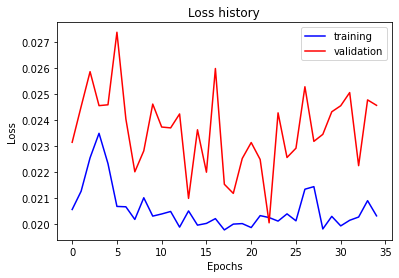

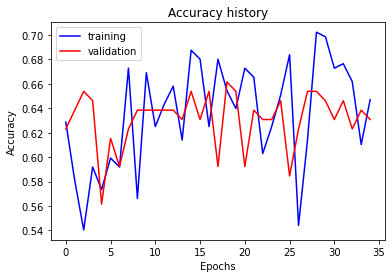

In [13]:
# save_plot = True
save_plot = False

trainer.plot_loss_history(save=save_plot)
trainer.plot_accuracy(save=save_plot)

In [17]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {}; Validation Accuracy = {}'.format(train_accuracy, validation_accuracy))

validation_loss = trainer.validation_loss_history[-1]
print(f'Final validation loss = {validation_loss}')

Train Accuracy = 0.5845588445663452; Validation Accuracy = 0.5692307949066162
Final validation loss = 0.04363517302733201


### Visualize and Analyze Confusion Matrix

The confusion matrix helps to get an idea about where and maybe why images are wrongly classified. The confusion matrix shows the predicted label vs. the ground truth label.

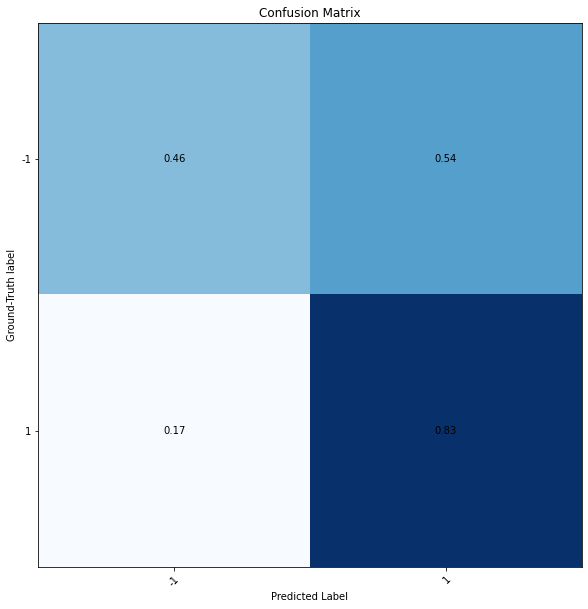

In [14]:
generate_and_plot_confusion_matrix(my_resnet, trainer.val_dataset, use_cuda=is_cuda)

In [34]:
save_trained_model_weights(my_resnet,
                           out_dir = '../dl_code/trained_models/',
                           loss = validation_loss)